In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
# Suppress warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import shap

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [75]:
# Read the CSV
df = pd.read_csv('C:/Users/User/Downloads/Kyushu Datasheets/data_with_press_and_weather.csv', low_memory=False)

# Drop rows with excessive missing values
missing_count = df.isnull().sum().sum()
if missing_count > 0:
    threshold = df.shape[1] // 2
    df = df.dropna(thresh=threshold + 1)
    print(f"Rows with more than half NaN dropped. Remaining rows: {len(df)}")
else:
    print("No missing values found.")

Rows with more than half NaN dropped. Remaining rows: 2811


In [76]:
# Clean and filter '강번'
df['강번'] = pd.to_numeric(df['강번'], errors='coerce')
df = df.dropna(subset=['강번'])
df = df[df['강번'].between(9000, 500000000)]
df = df[df['수율'].between(60, 100)]

#bad_ids = [2412006, 2411005]  # replace with the actual 강번 value(s)
#df = df[~df['강번'].isin(bad_ids)]

df.to_csv('For_my_use_1.csv', index=False)

# Make sure the date column is in datetime format
df['날짜'] = pd.to_datetime(df['날짜'], errors='coerce')

# 2) Choose the cutoff for test
test_start_date = pd.Timestamp('2024-09-22')

# 3) Split
train_df = df.loc[df['날짜'] <  test_start_date].sort_values('날짜').copy()
test_df  = df.loc[df['날짜'] >= test_start_date].sort_values('날짜').copy()

print("Train range:", train_df['날짜'].min(), "→", train_df['날짜'].max(), "rows:", len(train_df))
print("Test  range:", test_df['날짜'].min(),  "→", test_df['날짜'].max(),  "rows:", len(test_df))

Train range: 2024-01-04 00:00:00 → 2024-09-21 00:00:00 rows: 1949
Test  range: 2024-09-22 00:00:00 → 2024-12-28 00:00:00 rows: 844


In [77]:
# >>> ADDED: function to fill columns using previous valid value within mean±n*std else grade mean
def fill_with_prev_or_grade_mean(
    df_in,
    cols,
    *,
    grade_col="강종명",
    time_col="날짜",
    stats_df=None,   # None = training mode (use df_in stats); else use provided training stats
    n_std=3,
    drop_na=True
):
    """
    For each column in `cols`, use the previous heat's value from the same grade
    if it lies within [mean - n_std*std, mean + n_std*std] computed from `stats_df`.
    Otherwise fall back to the grade mean. Optionally drop remaining NaNs.
    Returns a copy of the dataframe.
    """
    if grade_col not in df_in.columns:
        raise KeyError(f"'{grade_col}' column not found in df")
    if time_col not in df_in.columns:
        raise KeyError(f"'{time_col}' column not found in df")
    for c in cols:
        if c not in df_in.columns:
            raise KeyError(f"'{c}' not found in df")

    out = df_in.copy()
    source = stats_df if stats_df is not None else out

    # compute stats from source
    grade_stats = source.groupby(grade_col)[cols].agg(["mean", "std"])

    # sort to align previous rows per grade
    out = out.sort_values(time_col)

    for c in cols:
        prev = out.groupby(grade_col)[c].shift(1)

        mean_by_grade = out[grade_col].map(grade_stats[(c, "mean")])
        std_by_grade  = out[grade_col].map(grade_stats[(c, "std")]).fillna(0)

        lower = mean_by_grade - n_std * std_by_grade
        upper = mean_by_grade + n_std * std_by_grade

        # default: grade mean
        new_vals = mean_by_grade.copy()

        # previous value is valid if within bounds and not NaN
        is_valid_prev = (
            prev.notna()
            & mean_by_grade.notna()
            & (prev >= lower)
            & (prev <= upper)
        )

        # use previous when valid
        new_vals[is_valid_prev] = prev[is_valid_prev]

        # if grade mean missing (unseen grade in stats_df), keep original as last fallback
        fallback_mask = new_vals.isna()
        if fallback_mask.any():
            new_vals.loc[fallback_mask] = out.loc[fallback_mask, c]

        out[c] = new_vals

        print(f"[{c}] prev-used: {is_valid_prev.sum():,} | mean-used: {(~is_valid_prev & mean_by_grade.notna()).sum():,} | remain-NaN: {out[c].isna().sum():,}")

    if drop_na:
        before = len(out)
        out = out.dropna(subset=cols)
        print(f"Dropped {before - len(out):,} rows with NaNs in {cols}")

    return out

In [78]:
# >>> ADDED: choose which columns to apply the logic to
# If you specifically want 'C-inj(佐山)', keep as is; otherwise replace with your additive column(s).
# This will quietly become [] if the column isn't present, so set it explicitly if needed.
candidate_cols = ['TAP-TAP', '온도', 'CaO', '사용전력량', 'O2사용량_합계'
]
additives_cols = [c for c in candidate_cols if c in train_df.columns or c in test_df.columns]
if not additives_cols:
    print("NOTE: No additives_cols found in data. Set `additives_cols = ['<your-column>']`.")

# >>> ADDED: Apply on TRAIN using its own stats; apply on TEST using TRAIN stats
if additives_cols:
    print("\n--- Applying prev-or-mean fill on TRAIN ---")
    processed_train_df = fill_with_prev_or_grade_mean(
        train_df,
        cols=additives_cols,
        grade_col="강종명",
        time_col="날짜",
        stats_df=None,   # training mode
        n_std=3,
        drop_na=True
    )

    print("\n--- Applying prev-or-mean fill on TEST (using TRAIN stats) ---")
    processed_test_df = fill_with_prev_or_grade_mean(
        test_df,
        cols=additives_cols,
        grade_col="강종명",
        time_col="날짜",
        stats_df=processed_train_df,  # inference mode
        n_std=3,
        drop_na=True
    )
else:
    # fall back to original if none selected
    processed_train_df = train_df.copy()
    processed_test_df  = test_df.copy()



--- Applying prev-or-mean fill on TRAIN ---
[TAP-TAP] prev-used: 1,940 | mean-used: 9 | remain-NaN: 0
[온도] prev-used: 1,877 | mean-used: 72 | remain-NaN: 0
[CaO] prev-used: 1,896 | mean-used: 53 | remain-NaN: 0
[사용전력량] prev-used: 1,931 | mean-used: 18 | remain-NaN: 0
[O2사용량_합계] prev-used: 1,934 | mean-used: 15 | remain-NaN: 0
Dropped 0 rows with NaNs in ['TAP-TAP', '온도', 'CaO', '사용전력량', 'O2사용량_합계']

--- Applying prev-or-mean fill on TEST (using TRAIN stats) ---
[TAP-TAP] prev-used: 816 | mean-used: 28 | remain-NaN: 0
[온도] prev-used: 813 | mean-used: 31 | remain-NaN: 0
[CaO] prev-used: 830 | mean-used: 14 | remain-NaN: 0
[사용전력량] prev-used: 840 | mean-used: 4 | remain-NaN: 0
[O2사용량_합계] prev-used: 840 | mean-used: 4 | remain-NaN: 0
Dropped 0 rows with NaNs in ['TAP-TAP', '온도', 'CaO', '사용전력량', 'O2사용량_합계']


In [79]:
# Target variable
target = 'CC_P'

'''
# Outlier removal
if 'Precipitation (mm)' in df.columns:
    initial_count_oxygen = len(df)
    df = df[df['Precipitation (mm)'] <= 10]
    removed_count_oxygen = initial_count_oxygen - len(df)
    print(f"Removed {removed_count_oxygen} rows where {'Precipitation (mm)'} > 10.")
else:
    print(f"Warning: '{'Precipitation (mm)'}' column not found.")
'''
# chin_variables = [col for col in df.columns if '친' in col and '친단' not in col]
# df['chin_total'] = df[chin_variables].sum(axis=1)

scraps_col = [
    '스크랩_S01_친',
    '스크랩_S01_자',
    # '스크랩_S01_손', # for GPR
    'A부스러기　친',
    'A부스러기 자',
    'A부스러기 손',
    # '친단　친', # for GPR
    '친단　자',
    '친단　손',
    '와셔 친',
    # '와셔 자', # for GPR
    # '와셔 손', # for GPR
    'B부스러기　친',
    'B부스러기 자',
    'B부스러기 손',
    '선다라이 친',
    # '선다라이 자', # for GPR
    # '선다라이 손', # for GPR
    # '류선 친', # for GPR
    '류선 자',
    # '류선 손', # for GPR
    '시타마와리(자동차 부품으로 예상됨)　친',
    # '시타마와리(자동차 부품으로 예상됨)　자', # for GPR
    # '시타마와리(자동차 부품으로 예상됨)　손', # for GPR
    '엔진 친',
    # '엔진 자',
    # '엔진 손',
    '슈레더 친',
    '슈레더 자',
    '슈레더 손',
    'C프레스 친',
    'C프레스 자',
    # 'C프레스 손', # for GPR
    # '다라이가루 친', # for GPR
    '다라이가루 자',
    '다라이가루 손',
    '강류 친',
    # '강류 자', # for GPR
    # '강류 손', # for GPR
    '타이어 친',
    # '타이어　자', # for GPR
    # '타이어　손', # for GPR
    '주물　친',
    # '주물　자', # for GPR
    # '주물　손', # for GPR
    # '알루미더스트　친', # for GPR
    # '알루미더스트　자', # for GPR
    # '알루미더스트　손', # for GPR
    # 'AB프레스　친', # for GPR
    # 'AB프레스　자', # for GPR
    # 'AB프레스　손', # for GPR
    # 'Mn강　친', # for GPR
    # 'Mn강　자', # for GPR
    # 'Mn강　손', # for GPR
    # '캔버서　친', # for GPR
    # '캔버서　자', # for GPR
    # '캔버서　손', # for GPR
    # '페인트캔　친', # for GPR
    # '페인트캔　자', # for GPR
    # '페인트캔　손', # for GPR
    'V프레스　친',
    # 'V프레스　자', # for GPR
    # 'V프레스　손', # for GPR
    # '캔프레스　친', # for GPR
    '캔프레스　자',
    # '캔프레스　손', # for GPR
    '빌렛부스러기　친',
    # '빌렛부스러기 자', # for GPR
    # '빌렛부스러기 손', # for GPR
    # 'SC（레들）바탕쇠　친', # for GPR
    'SC（레들）바탕쇠　자',
    # 'SC（레들）바탕쇠　손', # for GPR
    # 'EF바탕쇠　친', # for GPR
    'EF바탕쇠　자',
    # 'EF바탕쇠　손', # for GPR
    # 'CC바탕쇠　친', # for GPR
    # 'CC바탕쇠　자', # for GPR
    # 'CC바탕쇠　손', # for GPR
    '정비부스러기　친',
    # '정비부스러기　자', # for GPR
    # '정비부스러기　손', # for GPR
]

unusable_variables = candidate_cols
usable_variables = ['MD_C', 'MD_Mn', 'MD_Cr', 'MD_Si', 'MD_S', '장입량t']
other_variables = ['연회회수', 'Pressure_Local (hPa)', 'Pressure_SeaLevel (hPa)', 'Precipitation (mm)', 'Temperature (°C)', 'Relative Humidity (%)', 'WindSpeed_Avg (m/s)', 'WindSpeed_Max (m/s)']

chin_variables = [col for col in df.columns if '친' in col and '친단' not in col]
ja_variables = [col for col in df.columns if '자' in col]
son_variables = [col for col in df.columns if '손' in col]

scraps = chin_variables + ja_variables + son_variables

variables = scraps_col + usable_variables

# >>> ADDED: Build X/y from the processed train/test frames (NOT from the original df)
X_train = processed_train_df[variables].copy()
X_test  = processed_test_df[variables].copy()

target_col = [target]  # if you use this elsewhere
y_train = processed_train_df[target].copy()
y_test  = processed_test_df[target].copy()

In [80]:
# 1) Features (remove the date column if it's in your variables list)
feature_vars = [c for c in variables if c != '날짜']

X_train = train_df[feature_vars].copy()
X_test  = test_df[feature_vars].copy()

# 2) Targets
y_train = train_df[target].copy()
y_test  = test_df[target].copy()

print(X_train.columns)

Index(['스크랩_S01_친', '스크랩_S01_자', 'A부스러기　친', 'A부스러기 자', 'A부스러기 손', '친단　자',
       '친단　손', '와셔 친', 'B부스러기　친', 'B부스러기 자', 'B부스러기 손', '선다라이 친', '류선 자',
       '시타마와리(자동차 부품으로 예상됨)　친', '엔진 친', '슈레더 친', '슈레더 자', '슈레더 손', 'C프레스 친',
       'C프레스 자', '다라이가루 자', '다라이가루 손', '강류 친', '타이어 친', '주물　친', 'V프레스　친',
       '캔프레스　자', '빌렛부스러기　친', 'SC（레들）바탕쇠　자', 'EF바탕쇠　자', '정비부스러기　친', 'MD_C',
       'MD_Mn', 'MD_Cr', 'MD_Si', 'MD_S', '장입량t'],
      dtype='object')


In [81]:
print(len(X_train.columns))

37


In [82]:
# --- Model training and evaluation functions ---

def evaluate_model(name, model, X_train, y_train, X_test, y_test, df):
    print(f"\n--- {name} Model Evaluation ---")
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    # --- Calculate Metrics ---
    # Train
    mse_train = mean_squared_error(y_train, train_pred)
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(y_train, train_pred)
    mape_train = np.mean(np.abs((y_train - train_pred) / y_train)) * 100
    r2_train = r2_score(y_train, train_pred)

    # Test
    mse_test = mean_squared_error(y_test, test_pred)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_test, test_pred)
    mape_test = np.mean(np.abs((y_test - test_pred) / y_test)) * 100
    r2_test = r2_score(y_test, test_pred)

    # --- Print Metrics ---
    print(f"{name} Train Scores:")
    print(f"  MSE:  {mse_train:.2f}")
    print(f"  RMSE: {rmse_train:.2f}")
    print(f"  MAE:  {mae_train:.2f}")
    print(f"  MAPE: {mape_train:.2f}%")
    print(f"  R²:   {r2_train:.3f}")

    print(f"\n{name} Test Scores:")
    print(f"  MSE:  {mse_test:.2f}")
    print(f"  RMSE: {rmse_test:.2f}")
    print(f"  MAE:  {mae_test:.2f}")
    print(f"  MAPE: {mape_test:.2f}%")
    print(f"  R²:   {r2_test:.3f}")
    
    # Plot
    train_df = df[['강번']].loc[X_train.index].copy()
    train_df['Actual'] = y_train.values
    train_df['Predicted'] = train_pred
    train_df['Set'] = 'Train'

    test_df = df[['강번']].loc[X_test.index].copy()
    test_df['Actual'] = y_test.values
    test_df['Predicted'] = test_pred
    test_df['Set'] = 'Test'

    combined_df = pd.concat([train_df, test_df]).sort_values('강번').reset_index(drop=True)
    combined_df['Time Index'] = range(len(combined_df))

    plt.figure(figsize=(16, 4))
    plt.plot(combined_df['Time Index'], combined_df['Actual'], label='Actual', linewidth=2)
    plt.plot(combined_df['Time Index'], combined_df['Predicted'], label='Predicted', linestyle='--', linewidth=2)
    test_start = combined_df[combined_df['Set'] == 'Test']['Time Index'].min()
    plt.axvline(x=test_start, color='red', linestyle=':', label='Test Start')
    plt.xlabel('Time Index (chronological)')
    plt.ylabel(target)
    plt.title(f'Actual vs Predicted {target} ({name}) - R² = {r2_test:.3f}, RMSE = {rmse_test:.1f}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Test-only plot
    test_df = test_df.sort_values('강번').reset_index(drop=True)
    test_df['Time Index'] = range(len(test_df))

    plt.figure(figsize=(18, 3))
    plt.plot(test_df['Time Index'], test_df['Actual'], label='Actual', linewidth=2)
    plt.plot(test_df['Time Index'], test_df['Predicted'], label='Predicted', linestyle='--', linewidth=2)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [83]:
# --- Make models-safe: handle NaNs / infs and drop NaN targets ---

# 1) Ensure numeric + replace inf with NaN
X_train = X_train.apply(pd.to_numeric, errors='coerce').replace([np.inf, -np.inf], np.nan)
X_test  = X_test.apply(pd.to_numeric,  errors='coerce').replace([np.inf, -np.inf], np.nan)

# 2) Compute train medians for imputation (no leakage)
train_medians = X_train.median(numeric_only=True)

# If any column is all-NaN in train, fill those with 0 (or choose another constant) and warn
all_nan_cols = train_medians[train_medians.isna()].index.tolist()
if all_nan_cols:
    print("[WARN] All-NaN in TRAIN for:", all_nan_cols, "-> filling with 0")
    X_train[all_nan_cols] = 0
    X_test[all_nan_cols] = 0
    train_medians = X_train.median(numeric_only=True)

# 3) Impute
X_train = X_train.fillna(train_medians)
X_test  = X_test.fillna(train_medians)

# 4) Drop rows where target is NaN (and align indices)
train_mask = y_train.notna()
test_mask  = y_test.notna()
dropped_train = (~train_mask).sum()
dropped_test  = (~test_mask).sum()
if dropped_train or dropped_test:
    print(f"[INFO] Dropping {dropped_train} TRAIN and {dropped_test} TEST rows with NaN target")

X_train = X_train.loc[train_mask]
y_train = y_train.loc[train_mask]
X_test  = X_test.loc[test_mask]
y_test  = y_test.loc[test_mask]


[WARN] All-NaN in TRAIN for: ['스크랩_S01_친', '스크랩_S01_자'] -> filling with 0



--- Linear Regression Model Evaluation ---
Linear Regression Train Scores:
  MSE:  8.54
  RMSE: 2.92
  MAE:  2.26
  MAPE: 7.57%
  R²:   0.184

Linear Regression Test Scores:
  MSE:  6.17
  RMSE: 2.48
  MAE:  1.93
  MAPE: 6.61%
  R²:   0.011


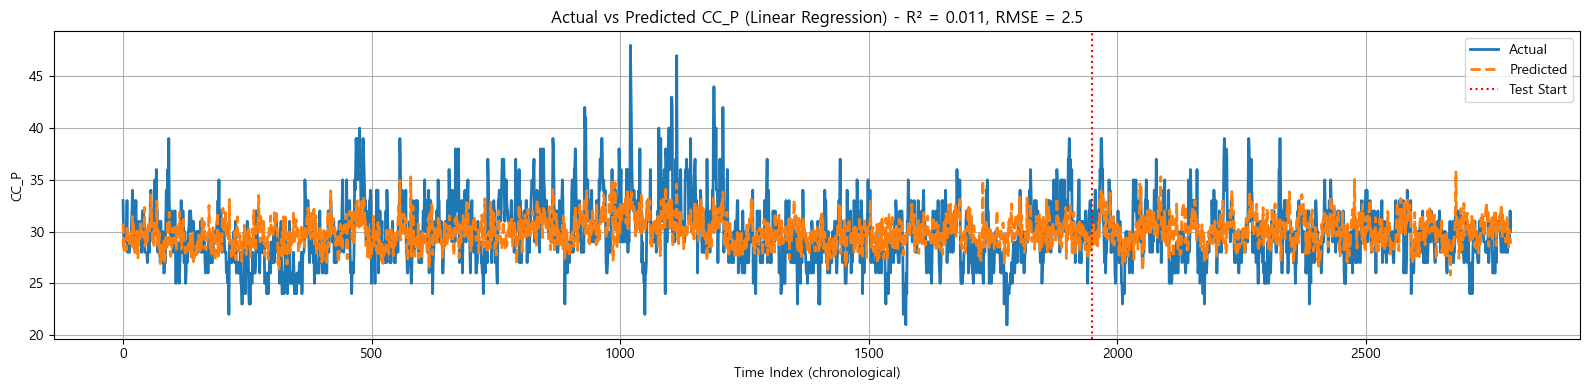

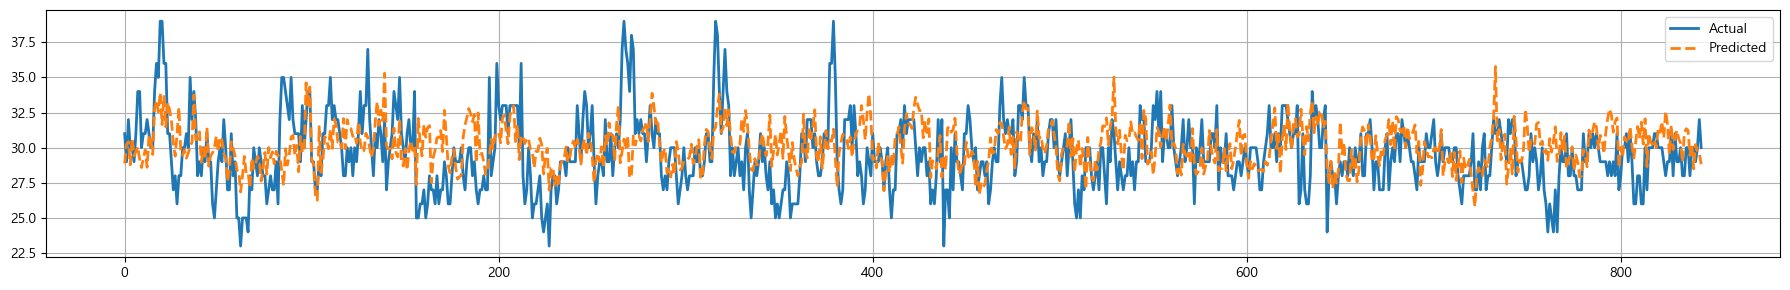

In [84]:
# --- Linear Regression ---
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
evaluate_model("Linear Regression", lin_model, X_train, y_train, X_test, y_test, df)


--- XGBoost Model Evaluation ---
XGBoost Train Scores:
  MSE:  5.47
  RMSE: 2.34
  MAE:  1.83
  MAPE: 6.11%
  R²:   0.477

XGBoost Test Scores:
  MSE:  5.97
  RMSE: 2.44
  MAE:  1.91
  MAPE: 6.56%
  R²:   0.043


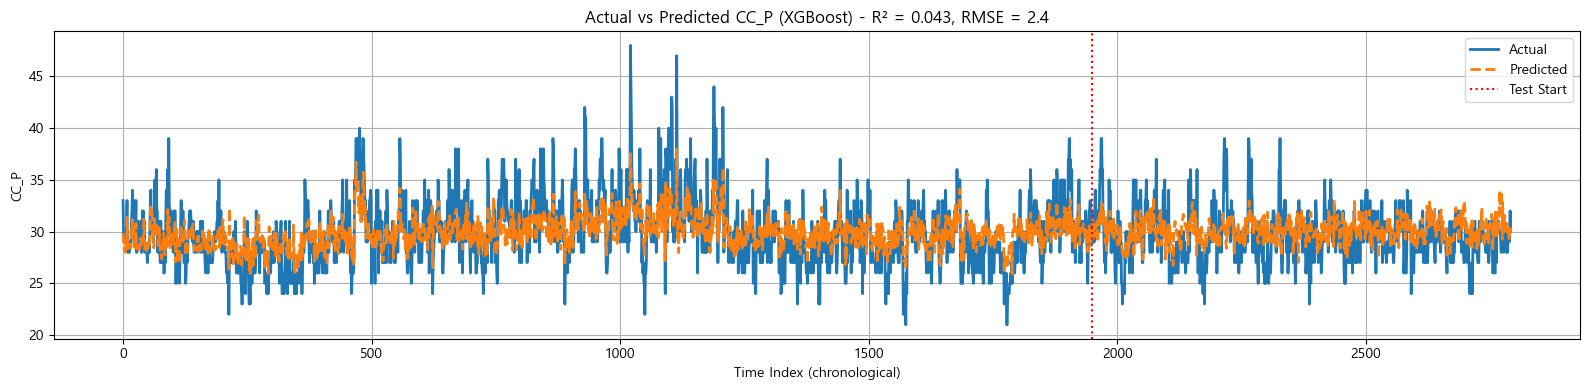

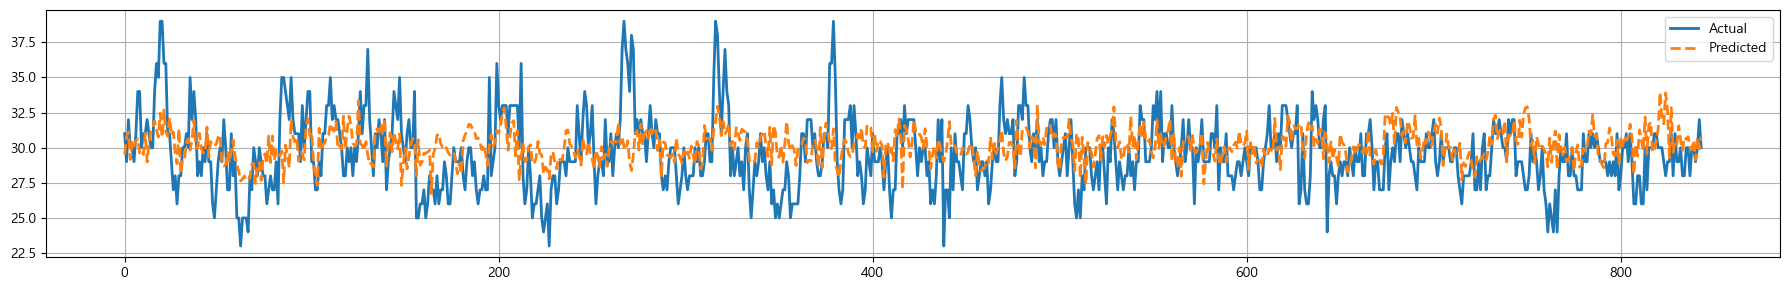

In [85]:
# --- XGBoost ---
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.005,
    max_depth=4,
    random_state=42
)
xgb_model.fit(X_train, y_train)
evaluate_model("XGBoost", xgb_model, X_train, y_train, X_test, y_test, df)


--- Random Forest Model Evaluation ---
Random Forest Train Scores:
  MSE:  1.06
  RMSE: 1.03
  MAE:  0.79
  MAPE: 2.62%
  R²:   0.899

Random Forest Test Scores:
  MSE:  6.15
  RMSE: 2.48
  MAE:  1.94
  MAPE: 6.67%
  R²:   0.014


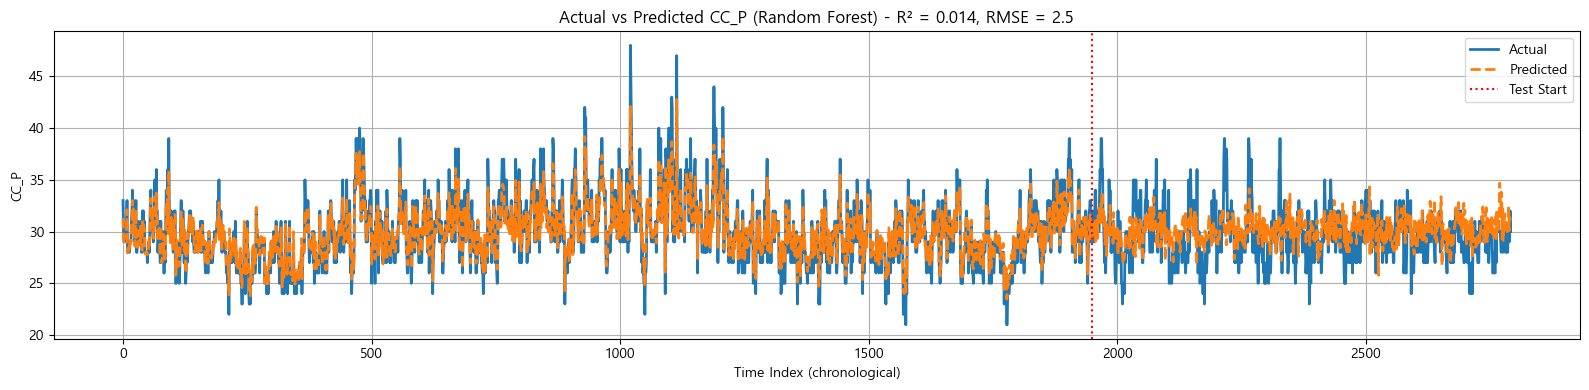

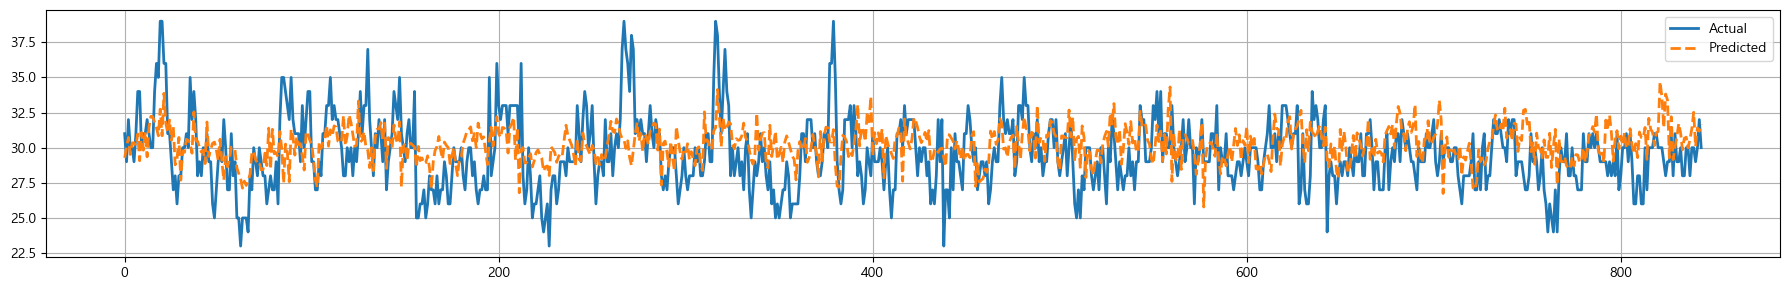

In [86]:
# --- Random Forest ---
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
evaluate_model("Random Forest", rf_model, X_train, y_train, X_test, y_test, df)

In [87]:

# === Added on 2025-08-08 05:01:32: safer evaluator for SVM/ANN (works with 1D/2D preds) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(name, model, X_train, y_train, X_test, y_test, df):
    print(f"\n--- {name} Model Evaluation ---")
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_pred = np.ravel(train_pred)
    test_pred = np.ravel(test_pred)

    ytr = np.ravel(np.array(y_train))
    yte = np.ravel(np.array(y_test))

    mse_train = mean_squared_error(ytr, train_pred)
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(ytr, train_pred)
    denom_tr = np.where(ytr == 0, np.finfo(float).eps, ytr)
    mape_train = np.mean(np.abs((ytr - train_pred) / denom_tr)) * 100
    r2_train = r2_score(ytr, train_pred)

    mse_test = mean_squared_error(yte, test_pred)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(yte, test_pred)
    denom_te = np.where(yte == 0, np.finfo(float).eps, yte)
    mape_test = np.mean(np.abs((yte - test_pred) / denom_te)) * 100
    r2_test = r2_score(yte, test_pred)

    print(f"{name} Train Scores:")
    print(f"  MSE:  {mse_train:.2f}")
    print(f"  RMSE: {rmse_train:.2f}")
    print(f"  MAE:  {mae_train:.2f}")
    print(f"  MAPE: {mape_train:.2f}%")
    print(f"  R²:   {r2_train:.3f}")

    print(f"\n{name} Test Scores:")
    print(f"  MSE:  {mse_test:.2f}")
    print(f"  RMSE: {rmse_test:.2f}")
    print(f"  MAE:  {mae_test:.2f}")
    print(f"  MAPE: {mape_test:.2f}%")
    print(f"  R²:   {r2_test:.3f}")

    train_df = df[['강번']].loc[X_train.index].copy()
    train_df['Actual'] = ytr
    train_df['Predicted'] = train_pred
    train_df['Set'] = 'Train'

    test_df = df[['강번']].loc[X_test.index].copy()
    test_df['orig_index'] = X_test.index
    test_df['Actual'] = yte
    test_df['Predicted'] = test_pred
    test_df['Set'] = 'Test'

    combined_df = pd.concat([train_df, test_df]).sort_values('강번').reset_index(drop=True)
    combined_df['Time Index'] = range(len(combined_df))

    plt.figure(figsize=(16, 4))
    plt.plot(combined_df['Time Index'], combined_df['Actual'], label='Actual', linewidth=2)
    plt.plot(combined_df['Time Index'], combined_df['Predicted'], label='Predicted', linestyle='--', linewidth=2)
    test_start = combined_df[combined_df['Set'] == 'Test']['Time Index'].min()
    if pd.notnull(test_start):
        plt.axvline(x=test_start, color='red', linestyle=':', label='Test Start')
    plt.xlabel('Time Index (chronological)')
    plt.ylabel(target)
    plt.title(f'Actual vs Predicted {target} ({name}) - R² = {r2_test:.3f}, RMSE = {rmse_test:.1f}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    test_df = test_df.sort_values('강번').reset_index(drop=True)
    test_df['Time Index'] = range(len(test_df))

    plt.figure(figsize=(18, 3))
    plt.plot(test_df['Time Index'], test_df['Actual'], label='Actual', linewidth=2)
    plt.plot(test_df['Time Index'], test_df['Predicted'], label='Predicted', linestyle='--', linewidth=2)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return test_df



--- SVR (RBF) Model Evaluation ---
SVR (RBF) Train Scores:
  MSE:  3.14
  RMSE: 1.77
  MAE:  0.98
  MAPE: 3.21%
  R²:   0.700

SVR (RBF) Test Scores:
  MSE:  6.67
  RMSE: 2.58
  MAE:  1.99
  MAPE: 6.77%
  R²:   -0.070


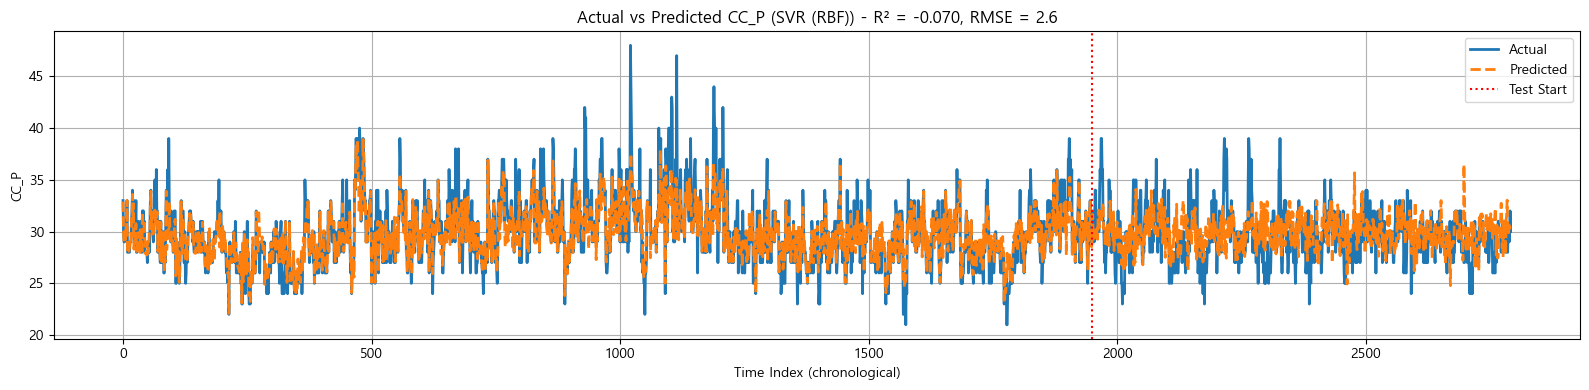

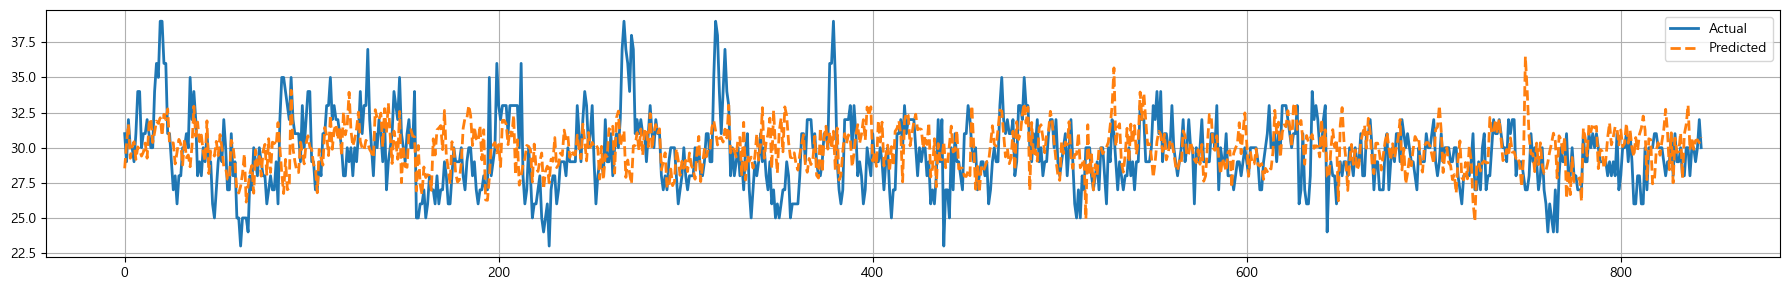

Iteration 1, loss = 193.91927209
Iteration 2, loss = 43.41885136
Iteration 3, loss = 22.82868564
Iteration 4, loss = 14.55356597
Iteration 5, loss = 10.34229926
Iteration 6, loss = 7.77264517
Iteration 7, loss = 6.31673859
Iteration 8, loss = 5.42849752
Iteration 9, loss = 4.83288803
Iteration 10, loss = 4.30096078
Iteration 11, loss = 3.82723731
Iteration 12, loss = 3.53854164
Iteration 13, loss = 3.35277021
Iteration 14, loss = 3.09970680
Iteration 15, loss = 2.93864455
Iteration 16, loss = 2.75222541
Iteration 17, loss = 2.57611400
Iteration 18, loss = 2.47490790
Iteration 19, loss = 2.38452708
Iteration 20, loss = 2.24474688
Iteration 21, loss = 2.24845140
Iteration 22, loss = 2.10650693
Iteration 23, loss = 1.89496951
Iteration 24, loss = 2.03789235
Iteration 25, loss = 1.80263454
Iteration 26, loss = 1.67650452
Iteration 27, loss = 1.52583654
Iteration 28, loss = 1.41222837
Iteration 29, loss = 1.36375923
Iteration 30, loss = 1.36459238
Iteration 31, loss = 1.21741216
Iteration 3

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


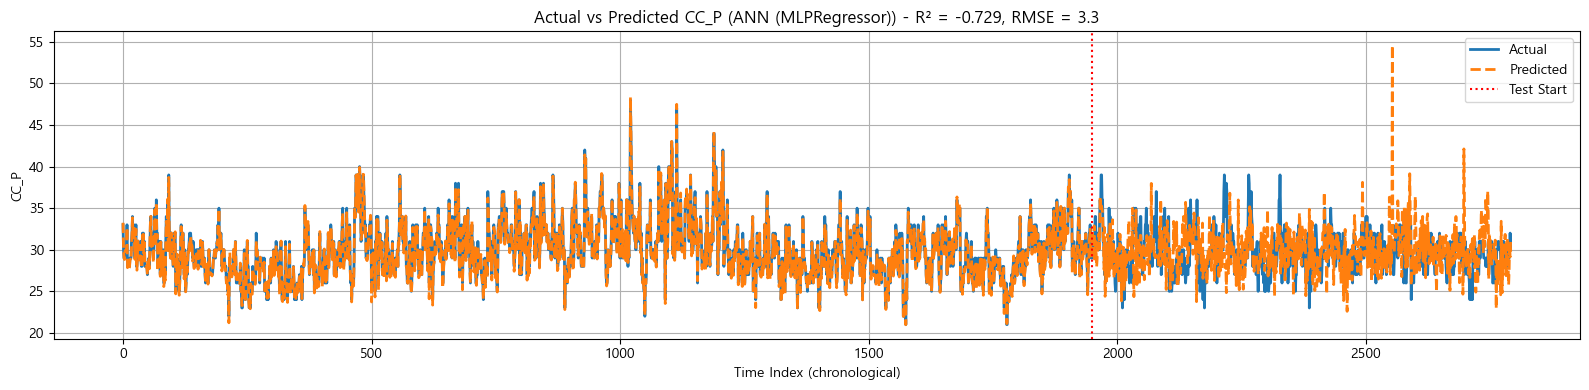

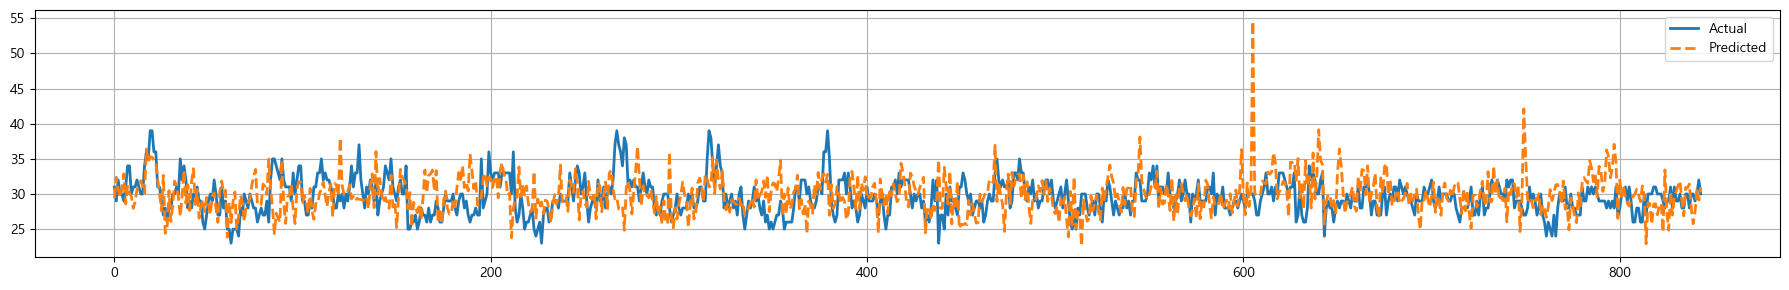

In [88]:

# === Added on 2025-08-08 05:01:32: SVM (SVR) and ANN (MLPRegressor) implementations ===
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# SVR pipeline (scale features)
svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf', C=10.0, epsilon=0.1, gamma='scale'))
])

svr_pipeline.fit(X_train, y_train)
svr_test_df = evaluate_model("SVR (RBF)", svr_pipeline, X_train, y_train, X_test, y_test, df)

# ANN pipeline (sigmoid as requested, 4x448, 500 iters, bs=50, verbose)
ann_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(
        hidden_layer_sizes=(128, 128, 128, 64),
        activation='relu',
        solver='adam',
        learning_rate='adaptive',
        batch_size=50,
        max_iter=500,
        early_stopping=False,      # don't use validation-based early stop
        n_iter_no_change=500,     # >> max_iter so it won't stop early
        tol=0.0,                   # require strict improvement (optional)
        random_state=42,
        verbose=True
    ))
])

ann_pipeline.fit(X_train, y_train)
ann_test_df = evaluate_model("ANN (MLPRegressor)", ann_pipeline, X_train, y_train, X_test, y_test, df)


In [89]:
# Option A: the max predicted value (your tall spike)
idx_spike = ann_test_df['Predicted'].idxmax()

row_spike = ann_test_df.loc[idx_spike]
print(row_spike[['강번','Actual','Predicted']])

강번           2412006.0
Actual            30.0
Predicted    54.583507
Name: 605, dtype: object


In [90]:
orig_idx = row_spike['orig_index']
x_row = X_test.loc[orig_idx]
display(x_row)  # what the model actually saw

스크랩_S01_친                    0.00
스크랩_S01_자                    0.00
A부스러기　친                   8000.00
A부스러기 자                   2200.00
A부스러기 손                   1300.00
친단　자                       500.00
친단　손                       500.00
와셔 친                       500.00
B부스러기　친                  11920.00
B부스러기 자                   9140.00
B부스러기 손                   6720.00
선다라이 친                    1000.00
류선 자                       500.00
시타마와리(자동차 부품으로 예상됨)　친      500.00
엔진 친                       500.00
슈레더 친                     6000.00
슈레더 자                     1600.00
슈레더 손                      300.00
C프레스 친                    1000.00
C프레스 자                     500.00
다라이가루 자                   1300.00
다라이가루 손                   1200.00
강류 친                       700.00
타이어 친                      100.00
주물　친                       300.00
V프레스　친                     400.00
캔프레스　자                     300.00
빌렛부스러기　친                   740.00
SC（레들）바탕쇠　자                600.00
EF바탕쇠　자       

In [91]:
comp = pd.DataFrame({
    'value': x_row,
    'train_min': X_train.min(),
    'train_max': X_train.max(),
})
comp['out_of_range'] = (comp['value']<comp['train_min']) | (comp['value']>comp['train_max'])
comp.sort_values('out_of_range', ascending=False, inplace=True)
print(comp[comp['out_of_range']])

       value  train_min  train_max  out_of_range
타이어 친  100.0      200.0      300.0          True


 95%|=================== | 1858/1949 [00:18<00:00]       


--- SHAP Summary: XGBoost ---


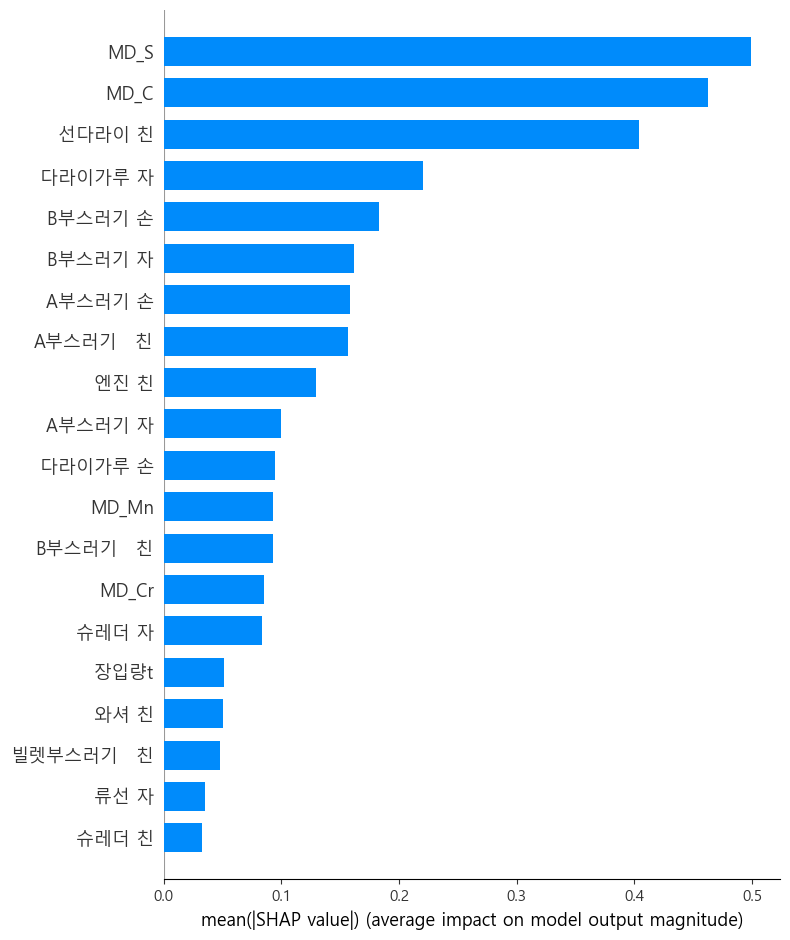

In [92]:
# SHAP for XGBoost (TreeExplainer is fast and accurate)
explainer_xgb = shap.Explainer(xgb_model, X_train)
shap_values_xgb = explainer_xgb(X_train)

# Global importance plot
print("\n--- SHAP Summary: XGBoost ---")
shap.summary_plot(shap_values_xgb, X_train, plot_type="bar")